In [2]:
print(df_cleaned.columns)

Index(['Hours per day', 'While working', 'Instrumentalist', 'Composer',
       'Fav genre', 'Frequency [Classical]', 'Frequency [Country]',
       'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]',
       'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]',
       'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]',
       'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]',
       'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety',
       'Depression', 'Insomnia', 'OCD', 'Music effects', 'obs_count'],
      dtype='object')


In [3]:
def convert_likert_to_numeric(df, freq_cols, mapping=None):
    if mapping is None:
        mapping = {
            "Never" : 0,
            "Rarely" : 1,
            "Sometimes" : 2,
            "Often" : 3,
            "Always" : 4,

        }
    df_converted = df.copy()
    for col in freq_cols:
        df_converted[col] = df_converted[col].map(mapping).fillna(0)
    
    return df_converted

In [ ]:
import pandas as pd
'''
Read in the music and mental health dataset to do some cleaning in order to do correlational testing.
This includes dropping unwanted columns, adding an observation count column, remapping the effects to
maintain consistency and then remapping them to a numerical value instead. We also convert the likert
scale in the dataset to numerical values with the above defined method to define the explanatory columns
before dropping unwanted columns from that dataframe as well.
'''

df = pd.read_csv("https://raw.githubusercontent.com/brobers0339/Musical_Impact_on_Mental_Health_Senior_Thesis/refs/heads/main/Music%26MentalHealthDataset.csv")

df_cleaned = df.drop(['Timestamp', 'Age', 'Primary streaming service', 'Exploratory', 'Permissions', 'BPM', 'Foreign languages'], axis=1)

df_cleaned['obs_count'] = range(1, len(df_cleaned) + 1)

df_cleaned['Effects_remapped'] = df_cleaned['Music effects'].map({
    'Improve' : 'Improved',
    'No effect' : 'No Effect',
    'Worsen' : 'Worsened',
    })

categories = {
    'Improved' : 1,
    'No Effect' : 2,
    'Worsened' : 3,
    'Unknown' : 0
}

df_cleaned['Effects_remapped'] = df_cleaned['Effects_remapped'].fillna('Unknown')
df_cleaned['Effects_remapped_cat'] = df_cleaned['Effects_remapped'].map(categories)

freq_cols = ['Frequency [Classical]', 
             'Frequency [Country]', 
             'Frequency [EDM]', 
             'Frequency [Folk]', 
             'Frequency [Gospel]', 
             'Frequency [Hip hop]', 
             'Frequency [Jazz]', 
             'Frequency [K pop]', 
             'Frequency [Latin]', 
             'Frequency [Lofi]', 
             'Frequency [Metal]', 
             'Frequency [Pop]', 
             'Frequency [R&B]', 
             'Frequency [Rap]', 
             'Frequency [Rock]', 
             'Frequency [Video game music]']

df_explanatory_cols = convert_likert_to_numeric(df_cleaned, freq_cols)
df_explanatory_cols = df_explanatory_cols.drop(['While working', 'Instrumentalist', 'Composer', 'Fav genre', 'Music effects', 'Effects_remapped', 'obs_count', 'Effects_remapped_cat'], axis=1)


In [ ]:
'''
Ordinal Logisitc Regression: 
    Using ordinal logistic regression, we attempt to predict the outcome of mental health 
    symptoms from each of the music categories to determine if there are any statistically
    significant correlations present between the two categories. 
'''

#Imports
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

#Create ordinal logistical regression model using the cleaned dataset with remapped
#effects column and the explanatory columns defined above.
model = OrderedModel(
    df_cleaned['Effects_remapped_cat'],
    df_explanatory_cols,
    distr='logit'
)

'''Fit the ordinal model using the Broyden-Fletcher-Goldfarb-Shanno
    algorithm, most popular minimizing optimization method as it improves the
    approximation of the computed Hessian matrix variables
'''
res = model.fit(method='bfgs')

#Fit model to a pandas dataframe to allow the data to be exported to a csv,
#and then therefore exported to a table to be used in the final report
model_df = pd.DataFrame({
    'Coef' : res.params,
    'Std Err' : res.bse,
    'z' : res.tvalues,
    'P>|z|' : res.pvalues,
    'CI_lower' : res.conf_int()[0],
    'CI_upper' : res.conf_int()[1]
})

#Write computed ordinal logistic regressional statistics to a csv file to be imported into final report
model_df.to_csv('ordinal_logistic_regression.csv', index=True)

Optimization terminated successfully.
         Current function value: 0.676787
         Iterations: 39
         Function evaluations: 41
         Gradient evaluations: 41


In [ ]:
'''
Spearman's Rank Correlation
    Using Spearman's rank correlation testing, we measure the strength between the 
    different ranked categories in the dataset. After calculating the spearman's r-value
    and p-values, we write that information to a dataframe to store and eventually export
    to a csv file in order to be implemented into the final report and findings.
'''

#Imports
from scipy.stats import spearmanr

#Define the correlational matrix the values will be added to
spearman_matrix = {'Category' : [], 'SpearmanR' : [], 'p-value' : []}

for col in df_explanatory_cols:
    corr, pval = spearmanr(df_cleaned['Effects_remapped_cat'], df_explanatory_cols[col])
    spearman_matrix['Category'].append(col)
    spearman_matrix['SpearmanR'].append(corr)
    spearman_matrix['p-value'].append(pval)

spearman_df = pd.DataFrame(spearman_matrix)

spearman_df.to_csv('spearman_correlation.csv', index=False)

In [ ]:
#Visualization testing for Ordinal Logit Regression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

model_df = pd.DataFrame({
    'category' : res.params.index,
    'coefficients' : res.params.values,
    'std error': res.bse.values
})

prediction_grid = {}

for col in freq_cols: #iterate through each column involving genre frequency

    #Create 10 evenly spaced points from min to max
    x_range = np.linspace(df_explanatory_cols[col].min(), df_explanatory_cols[col].max(), 10)
    
    #Create base dataframe with all predictors at their mean
    means = pd.DataFrame([df_explanatory_cols.mean()])

    #Repeat mean row 100 times to make the dataframe same size
    predictors = pd.DataFrame(np.repeat(means, len(x_range), axis=0), columns=means.columns)

    #Replace current column values
    predictors[col] = x_range

    #Store each predictor grid created
    prediction_grid[col] = predictors


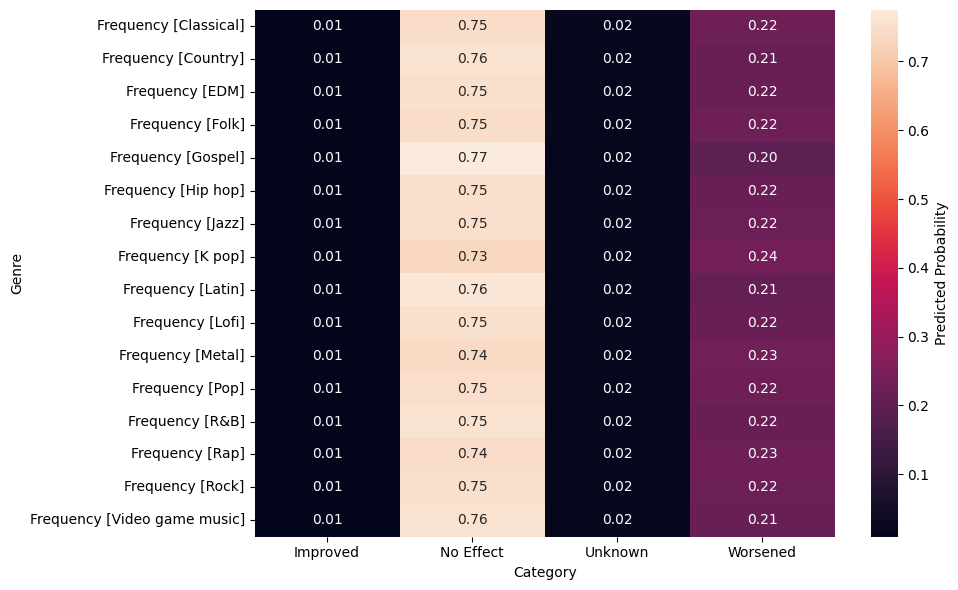

In [42]:
all_predictors = []
category_labels = {1 : "Improved", 2: "No Effect", 3 : "Worsened", 0 : "Unknown"}

for genre, predictors in prediction_grid.items():

    #predictors = predictors[res.model.exog_names]

    probabilities = res.model.predict(res.params, exog=predictors)

    probability_df = pd.DataFrame(probabilities, columns=[1, 2, 3, 0])
    probability_df['Genre'] = genre
    probability_df['Frequency Lvl'] = np.linspace(0, 1, len(probability_df))

    all_predictors.append(probability_df)

predictors_df = pd.concat(all_predictors, ignore_index=True)

combined_predictors = predictors_df.melt(
    id_vars=['Genre', 'Frequency Lvl'],
    var_name='Category',
    value_name='Prediction Prob'
)

combined_predictors['Category'] = combined_predictors['Category'].map(category_labels)


avg_predictor = (
    combined_predictors
    .groupby(['Genre', 'Category'], as_index=False)['Prediction Prob']
    .mean()
)

heatmap_data = avg_predictor.pivot(index='Genre', columns='Category', values='Prediction Prob')

plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cbar_kws={'label': 'Predicted Probability'})
plt.tight_layout()
plt.show()

In [ ]:
#Visualization testing for spearman's
mask = spearman_df['p-value'] > 0.05

heatmap_data = spearman_df.set_index('Category')[['p-value']]

np.fill_diagonal(heatmap_data.values, 1)

plt.figure(figsize=(10, 8))

sns.heatmap(heatmap_data, annot=True)
plt.show()